# Detecting anomalies in wind turbines

In this notebook, we will illustrate how to use ``dtaianomaly`` for detecting anomalies in an industrial use case: wind turbines. For this, we will first load the data using a custom data loader, verify the performance of various anomaly detectors in a train set, and then finally detect anomalies in a test set.  

In [1]:
from dtaianomaly.data import PathDataLoader, DataSet
from dtaianomaly.preprocessing import Preprocessor
from dtaianomaly.anomaly_detection import IsolationForest, LocalOutlierFactor, MatrixProfileDetector
from dtaianomaly.pipeline import Pipeline
from dtaianomaly.thresholding import ContaminationRate
from dtaianomaly.evaluation import Precision, Recall, FBeta, AreaUnderROC
from dtaianomaly.workflow import Workflow

In [2]:
# Additional (non-dtaianomaly) dependencies for various utilities
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Penmashiel wind turbine dataset

For this example, we focus on the publicly available Penmanshiel dataset [1]. First we will describe the data, and then we show how to load it easily within ``dtaianomaly`` using a custom data loader. 

#### Data understanding 

The Penmanshiel wind farm is a group of wind turbines located in the South-East of Scotland. It consists of 14 Senvion MM82 turbines, with data collected over a period of 6.5 years (from 2016 until mid-2021). Several types of information are available within this dataset:
1. 10-minute SCADA and events data from each turbine in the Penmanshiel group. Note not all signals are available for the entire period;
2. Static data including turbine coordinates and turbine details (rated power, rotor diameter, hub height, etc.);
3. Data mappings from primary SCADA to csv signal names;
4. Site substation/PMU meter data where available over the same period;
5. Site fiscal/grid meter data where available over the same period.  

Here, we focus on the 10-minute SCADA time series data to detect anomalies.

#### Data loading

The first step to detect anomalies is to load the data. The entire dataset can be downloaded from [1]. Once the data has been downloaded and unzipped (as well as unzipping the inner zip-files), we can start loading the data. For nicely structured data, you could simply call something like ``pd.read_csv("path-to-data.csv")``. However, the Penmanshiel dataset consists of a large number of files, which should be read, aggregated and formatted. For these datasets, ``dtaianomaly`` offers the ``PathDataLoader``, a class for implementing the logic to read a dataset, after which the data can be read using a single function call. Below, we implement the ``PenmanshielDataLoader`` as a child of the ``PathDataLoader``, which will format the observational data and ground truth labels in numpy arrays. 

Additionally, we implemented logic to split the dataset into a train and test set. It is also possible to use the internal train and test separation of a ``DataSet``, but we choose to not use this for this use case. The reason is that we want to verify the performance of various unsupervised anomaly detectors on a train set, and the use that detector to estimate the performance on the future test set. If we used the train and test set of a ``DataSet``, then we would evaluate all the anomaly detectors on the test set while being trained on the train set, without being able to do further predictions of the best anomaly detector on an addition data set. 

> Note that we implement the ``_load()`` method (with preceding underscore) instead of the ``load()`` method (without preceding underscore). That is because the ``PathDataLoader`` automatically supports caching data depending on the ``do_caching`` parameter. This is especially beneficial for large datasets such as the penmanshiel wind turbine data. By implementing the ``_load()`` method, you do not have to worry about caching the data. 

In [3]:
class PenmanshielDataLoader(PathDataLoader):

    def __init__(self, 
                 path: str, 
                 do_caching: bool, 
                 turbine_name: str, 
                 attribute: str, 
                 train_size: float, 
                 return_train_data: bool):
        super().__init__(path, do_caching)
        self.turbine_name: str = turbine_name
        self.attribute: str = attribute
        self.train_size: float = train_size
        self.return_train_data: bool = return_train_data
        
    def _load(self) -> DataSet:
        # Lists for the individual data frames
        status_data_frames = []
        turbine_data_frames = []
        
        # Iterate over all the directories in the path
        for sub_directory in os.listdir(self.path):
            
            # Skip non-SCADA data
            if not sub_directory.startswith('Penmanshiel_SCADA'):
                continue
            
            # Iterate over all the files in the directory
            for file_name in os.listdir(f'{self.path}/{sub_directory}'):
                
                # Skip files for other assets 
                if self.turbine_name.replace(' ', '_') not in file_name:
                    continue
                
                # Read the status data
                if file_name.startswith('Status'):
                    status_data = pd.read_csv(
                        f'{self.path}/{sub_directory}/{file_name}',
                        skiprows=9,
                        parse_dates=['Timestamp start'],
                        date_format='%Y-%m-%d %H:%M:%S'
                    )
                    status_data['Timestamp end'] = pd.to_datetime(status_data['Timestamp end'], errors='coerce', format='%Y-%m-%d %H:%M:%S')
                    status_data['Duration'] = pd.to_timedelta(status_data['Duration'], errors='coerce')
                    status_data_frames.append(status_data)
                
                # Read the turbine data
                if file_name.startswith('Turbine'):
                    turbine_data = pd.read_csv(
                        f'{self.path}/{sub_directory}/{file_name}',
                        skiprows=9,
                        parse_dates=['# Date and time']
                    ).rename(columns={'# Date and time': 'Date and time'}).set_index('Date and time')
                    turbine_data_frames.append(turbine_data[self.attribute])
        
        # Create one frame for the status and turbine data
        status_data = pd.concat(status_data_frames) 
        turbine_data = pd.concat(turbine_data_frames).resample('10min').asfreq()  # FIll in missing values with nan
        
        # Format the anomalous time steps
        anomalies = pd.Series(index=turbine_data.index, data=0.0, name='anomalies')
        for _, event in status_data[status_data['Status'] == 'Stop'].iterrows():
            anomalies.loc[event['Timestamp start']:event['Timestamp end']] = 1
        
        # Return either the train or test set 
        nb_instances_train_set = int(turbine_data.shape[0] * self.train_size)
        if self.return_train_data:
            return DataSet(X_test=turbine_data.values[:nb_instances_train_set], y_test=anomalies.values[:nb_instances_train_set])
        else:
            return DataSet(X_test=turbine_data.values[nb_instances_train_set:], y_test=anomalies.values[nb_instances_train_set:])

Now we can simply load the penmanshiel data by instantiating a ``PenmanshielDataLoader`` and calling the ``load()`` method, as is shown below. This method returns a ``DataSet``-object with ``X`` the raw time series data and ``y`` the ground truth anomaly labels. We will load both a train and test set, in which we use the first 10% of the data for training and the remaining 90% for testing. 

In [4]:
train_loader = PenmanshielDataLoader(
    path='../data/Penmanshiel', 
    do_caching=True,
    turbine_name='Penmanshiel 01', 
    attribute='Lost Production Total (kWh)',
    train_size=0.1,
    return_train_data=True
)
train_set = train_loader.load()

In [5]:
test_loader = PenmanshielDataLoader(
    path='../data/Penmanshiel', 
    do_caching=True,
    turbine_name='Penmanshiel 01', 
    attribute='Lost Production Total (kWh)',
    train_size=0.1,
    return_train_data=False  # Make sure to load the test data!
)
test_set = test_loader.load()

Below, we plot the time series to visually inspect the data and to obtain a general idea of what the data looks like. 

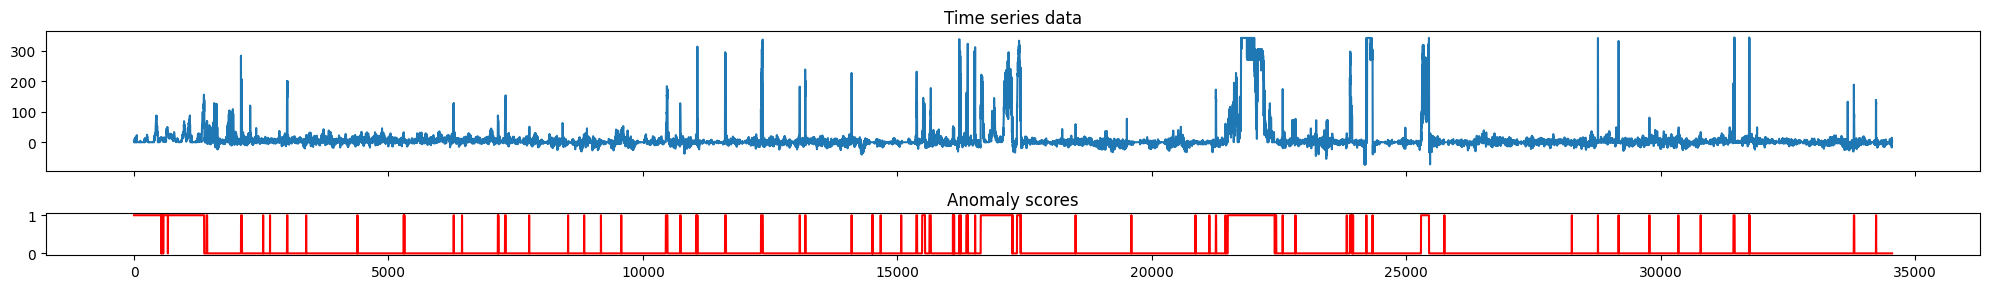

In [6]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(20, 3), sharex='all', height_ratios=[1, 0.3])
ax1.plot(train_set.x)
ax1.set_title('Time series data')
ax2.plot(train_set.y, color='red')
ax2.set_title('Anomaly scores')
fig.tight_layout()

### Detecting anomalies

Once the time series data has been loaded, it is possible to detect anomalies with ``dtaianomaly``. Anomaly detection is inherently an unsupervised task, because in many applications it is difficult (or even impossible) to obtain a large set of anomaly labels. However, here this information is available. Therefore, we will detect anomalies on the train set, and then select the best model to detect anomalies in the test set. 

#### Train-phase

For the train-phase, we will use the ``Workflow`` in ``dtaianomaly`` to easily measure the performance of multiple models. For this, we need to initialize a number of components: (1) data loaders, (2) preprocessors, (3) anomaly detectors, and (4) evaluation metrics. The ``Workflow`` will apply every anomaly detector combined with every preprocessor on every data set in a grid-like manner, and compute each performance metric. 

##### (1) Data loaders

Above we defined the ``PenmanshielDataLoader``. We can simply use this loader within the ``Workflow`` to load the pensmanshiel dataset. Note, however, that the data will be loaded for each combination of anomaly detector and preprocessor. Therefore, it is beneficial to enable caching by setting ``do_caching=true`` upon initialization (as was done above). 

In [7]:
dataloaders = train_loader

##### (2) Preprocessors

Next, we can define zero, one or multiple preprocessors to process the data. ``dtaianomaly`` already offers a number of preprocessors, (e.g., ``MinMaxScaler``, ``StandardScaler``, ``MovingAverage``, ``ChainedPreprocessor``, etc.), but it is also possible to develop a custom preprocessor. For example, the wind turbine data has missing values, which typically cannot be handled by anomaly detectors. To cope with these, we define an ``Imputer`` preprocessor as below. All we need to do for this is add ``Preprocessor`` as a parent of the class and implement the ``._fit()`` and ``._transform()`` methods. For the ``Imputer``, no fitting is required, and the missing values are replaced by the previous observed value. Note that more complex imputation strategies could be implemented as well. 

In [8]:
class Imputer(Preprocessor):
    
    def _fit(self, X, y=None) -> 'Preprocessor':
        return self

    def _transform(self, X, y=None) -> (np.ndarray, np.ndarray):
        for i in range(X.shape[0]):  
            if np.isnan(X[i]):
                X[i] = X[i-1]
            if y is not None:
                if np.isnan(y[i]):
                    y[i] = y[i-1]
        return X, y

preprocessors = Imputer()

##### (3) Anomaly detectors 

In this example, we will measure the performance of three anomaly detectors:
1. **Isolation Forest** generates a set of random trees, in which each node separates the dataset. The assumption is that nodes near the root of the tree are more easily separated than the leaf nodes. Consequently, an anomaly score is derived based on the average height of an observation in the trees. The input of the Isolation Forest is a window in the time series, i.e., a sequence of consecutive measurements. 
2. **Local Outlier Factor** measures the local density of each instance and compares it with the density of neighboring instances. If the neighbors of an instance are in much denser regions of the feature space than the instance itself, then the instance is assumed to be anomalous. Similarly to Isolation forest, the input of Local Outlier Factor is a window in the time series.
3. **Matrix Profile** equals the z-normalized Euclidean distance of each window to its nearest neighbor. Thus, if a window has a large matrix profile value, the nearest neighbor of that window is far away. These windows are considered anomalies. 

In [9]:
detectors = [
    IsolationForest(window_size=15),
    LocalOutlierFactor(window_size=15),
    MatrixProfileDetector(window_size=15)
]

##### (4) Metrics

Finally, we initialize the metrics to compute for the qualitative evaluation of the different anomaly detectors. However, anomaly detectors typically predict anomaly scores (*"How anomalous is the observation?"*), while many metrics such as precision and recall require binary labels (*"Is the observation an anomaly?"*). For metrics requiring binary labels, we can apply some thresholding. Below, we use the ``ContaminationRate`` threshold, which ensures that the observations with the largest anomaly scores are anomalous, such that $r%$ of the data is an anomaly. Within the ``WorkFlow``, multiple thresholds can be provided, and each threshold will be combined with each binary metric to evaluate the anomaly detector.

In [10]:
thresholds = ContaminationRate(0.1)
metrics = [Precision(), Recall(), FBeta(beta=1), AreaUnderROC()]

##### Running a workflow

Once the different components have been initialized, we can pass them to a ``Workflow``-object and compute the performances by calling the ``run()`` method.  

In [11]:
workflow = Workflow(
    dataloaders=dataloaders,
    preprocessors=preprocessors,
    detectors=detectors,
    metrics=metrics,
    thresholds=thresholds
)
workflow.run()

,Dataset,Detector,Preprocessor,Runtime [s],ContaminationRate(contamination_rate=0.1)->Precision(),ContaminationRate(contamination_rate=0.1)->Recall(),ContaminationRate(contamination_rate=0.1)->FBeta(),AreaUnderROC()
0,PenmanshielDataLoader(path='../data/Penmanshie...,IsolationForest(window_size=15),Imputer(),0.942256,0.592185,0.556886,0.573994,0.751767
1,PenmanshielDataLoader(path='../data/Penmanshie...,LocalOutlierFactor(window_size=15),Imputer(),22.747347,0.149349,0.140446,0.144761,0.319410
2,PenmanshielDataLoader(path='../data/Penmanshie...,MatrixProfileDetector(window_size=15),Imputer(),40.700633,0.006078,0.005716,0.005891,0.190466


#### Test-phase

From the evaluations in the train set, we saw that Isolation Forest is best suitable to detect anomalies in the Penmanshiel data set. Below, we initialize a new anomaly detector to detect anomalies in the test set. In order to preprocess and detect anomalies in one flow, we combine the ``Imputer`` and ``IsolationForest`` in a ``Pipeline``. The ``fit()`` and ``predict_proba()`` methods will then automatically apply preprocessing and anomaly detection. 

In [12]:
detector = Pipeline(
    preprocessor=Imputer(),
    detector=IsolationForest(window_size=15)
)
y_pred = detector.fit(train_set.x).predict_proba(test_set.x)

Because we have ground truth labels available for the test set, we can compute the Area Under the ROC-curve, and see that the detector is well-suited for detecting anomalies in the Penmanshiel data set!

In [13]:
auc_roc = AreaUnderROC()
f'AUC-ROC: {auc_roc.compute(test_set.y, y_pred)}'

'AUC-ROC: 0.8548885093007168'

Finally, the predictions can be visually analyzed by plotting the time series, the ground truth anomaly scores, and the predicted anomaly scores, as is done below. 

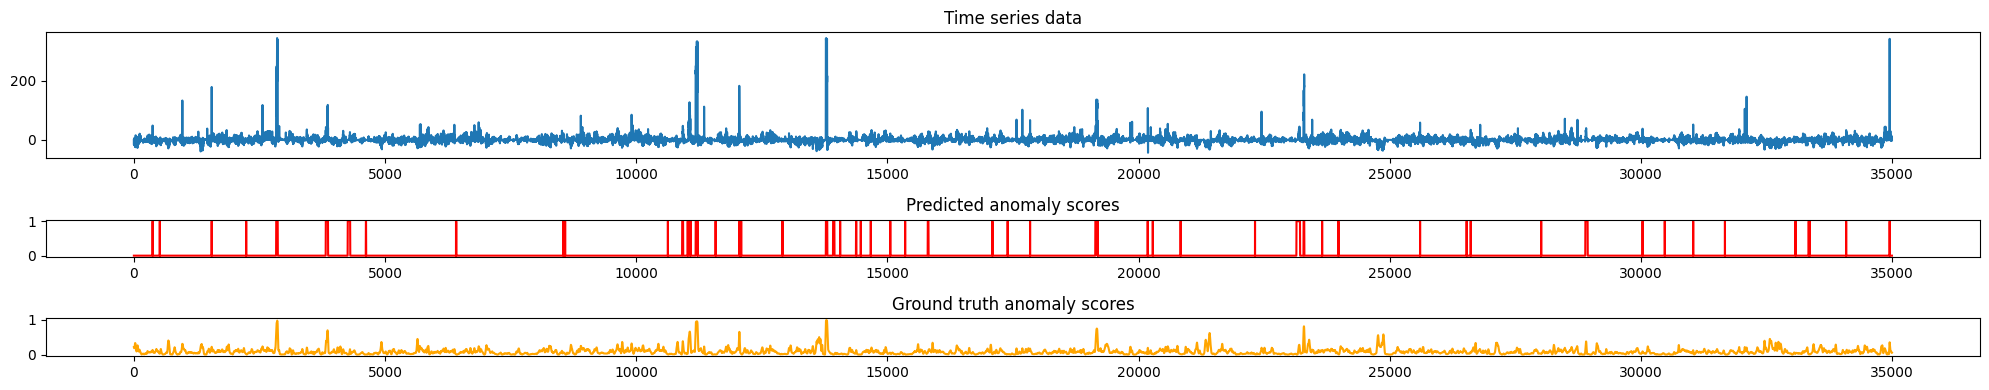

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(20, 4), height_ratios=[1, 0.3, 0.3])
NB_OBSERVATIONS = 35000
ax1.plot(test_set.x[:NB_OBSERVATIONS])
ax1.set_title('Time series data')
ax2.plot(test_set.y[:NB_OBSERVATIONS], color='red')
ax2.set_title('Predicted anomaly scores')
ax3.plot(y_pred[:NB_OBSERVATIONS], color='orange')
ax3.set_title('Ground truth anomaly scores')
fig.tight_layout()

# References

[1] Plumley, Charlie. "Penmanshiel Wind Farm Data". Zenodo, 7 februari 2022, [doi: 10.5281/zenodo.8253010](https://doi.org/10.5281/zenodo.8253010).